In [210]:
import pandas as pd
import numpy as np

# Plotting and correlation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy import stats

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

Use monthly demand to predict emissions

**Load data**

In [43]:
fuel_types = ['electric','plug-in hybrid electric','fuel cell','diesel','flex fuel','gasoline','gasoline hybrid','natural gas','propane']

# CA monthly CO2 emissions and demand

df = pd.read_csv('data/monthly_all_data.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df.drop(columns=fuel_types)

print(f"shape: {df.shape}")
df.head()

shape: (96, 4)


,date,demand,emissions,date_idx
0,202112,11489598.82,4959996.71,95
1,202111,10731961.28,4365100.13,94
2,202110,12062383.69,4577134.35,93
3,202109,13537589.39,5070292.57,92
4,202108,15754584.69,5607233.68,91


In [196]:
df.describe()

,date,demand,emissions,date_idx
count,96.000000,9.600000e+01,9.600000e+01,96.000000
mean,201756.500000,1.291460e+07,4.725586e+06,47.500000
std,230.357708,2.283262e+06,1.009228e+06,27.856777
min,201401.000000,8.855928e+06,2.569253e+06,0.000000
25%,201578.750000,1.130356e+07,4.103406e+06,23.750000
50%,201756.500000,1.237819e+07,4.772194e+06,47.500000
75%,201934.250000,1.426933e+07,5.383475e+06,71.250000
max,202112.000000,1.825466e+07,6.904020e+06,95.000000


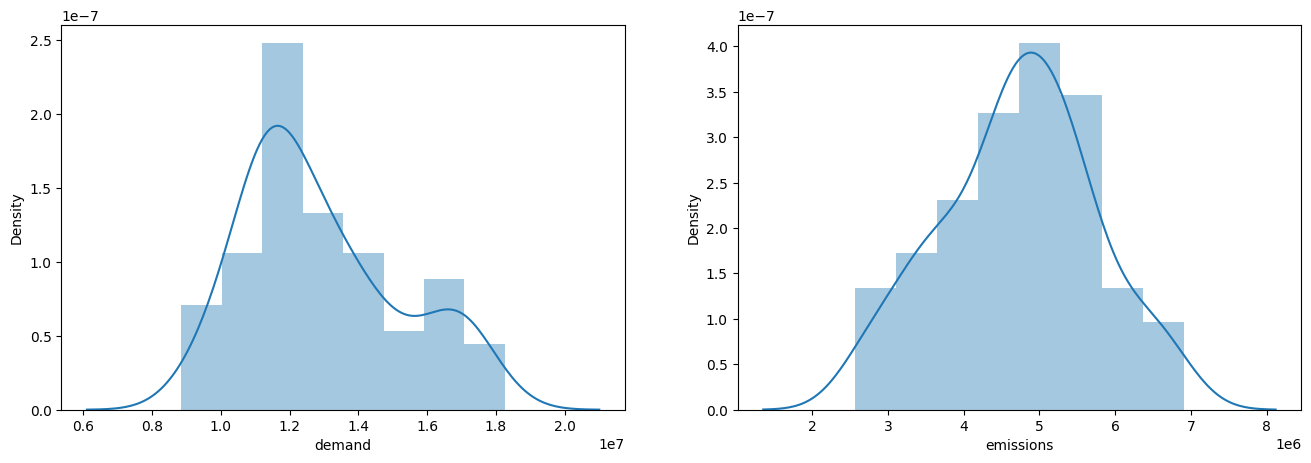

In [195]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['demand'])
plt.subplot(1,2,2)
sns.distplot(df['emissions'])
plt.show()

**Emissions/demand correlation**

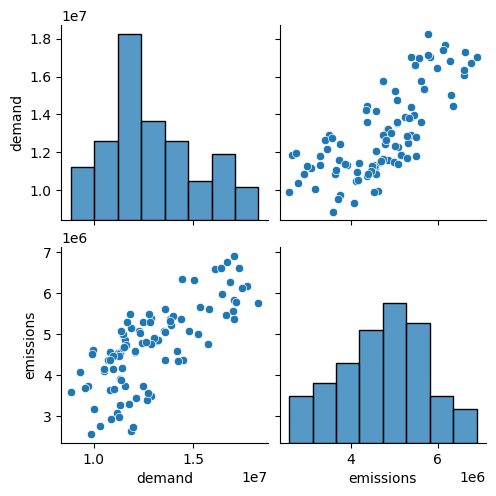

In [197]:
ed = df[['demand','emissions']]

sns.pairplot(ed, kind="scatter")
plt.show()

In [198]:
corrcoef = np.corrcoef(df['demand'], df['emissions'])[0,1]
print(f'Correlation coefficient: {corrcoef}')

p_value = linregress(df['demand'], df['emissions']).pvalue
print(f'p-value: {p_value}')

Correlation coefficient: 0.7392691356865783
p-value: 7.943737354383614e-18


**Linear regression**

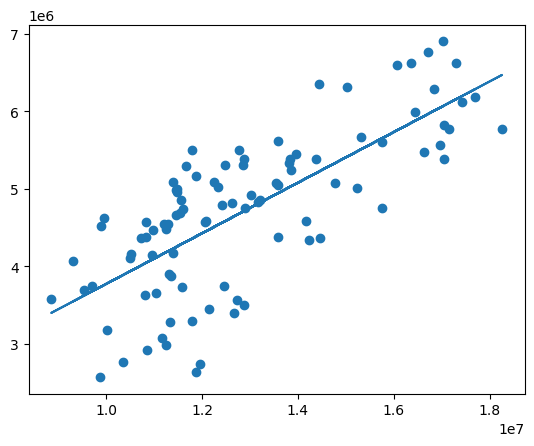

Correlation coefficient: 0.7392691356865783


In [206]:
X = df["demand"]
y = df["emissions"]

slope, intercept, r, p, std_err = stats.linregress(X, y)

def lin_func(X):
  return slope * X + intercept

linreg_model = list(map(lin_func, X))

plt.scatter(X, y)
plt.plot(X, linreg_model)
plt.show()

print(f'Correlation coefficient: {r}')

**Polynomial regression**

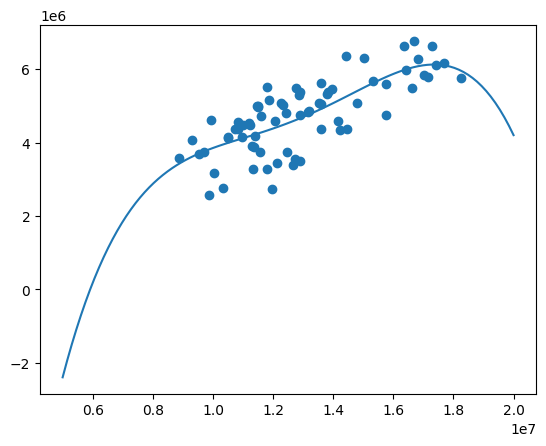

model score on training data : 0.5722769261691387
model score on testing data: 0.49510003281039316


In [207]:
X = df["demand"]
y = df["emissions"]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25)

poly_reg = np.poly1d(np.polyfit(X_train, y_train, 4))

poly_reg_line = np.linspace(5000000, 20000000, 100)

plt.scatter(X_train, y_train)
plt.plot(poly_reg_line, poly_reg(poly_reg_line))
plt.show()

print(f'model score on training data : {r2_score(y_train, poly_reg(X_train))}')
print(f'model score on testing data: {r2_score(y_test, poly_reg(X_test))}')

**Logistic regression**

In [224]:
X = df.drop(columns=["date","emissions","date_idx"])
y = df["emissions"]
y = df.astype[{'emissions': 'int'}]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

model = LogisticRegression()
model.fit(X_train,y_train)

predictions = model.predict(X_test)
# log_reg = LogisticRegression()
# log_reg.fit(X,y)

# print(f'Testing data score: {log_reg.score(X_train, y_train)}')
# print(f'Testing data score: {log_reg.score(X_test, y_test)}')

TypeError: 'method' object is not subscriptable

**Random forest**

In [205]:
# Random forest regressor

X = df.drop(columns=["date","emissions","date_idx"])
y = df["emissions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

distribution = {
        'n_estimators': [2,3,5,10,20,50,100,200],  
        'max_features': ['sqrt','log2','auto'],
       }

random_forest = RandomForestRegressor()
rscv = RandomizedSearchCV(estimator = random_forest, param_distributions = distribution, n_iter = 10)                
rscv.fit(X_train,  y_train)

print(f'Best parameters: {rscv.best_params_}')
print(f'Training data score: {rscv.score(X_train,  y_train)}')
print(f'Testing data score: {rscv.score(X_test, y_test)}')


Best parameters: {'n_estimators': 50, 'max_features': 'sqrt'}
Training data score: 0.9067609702164486
Testing data score: 0.38740808066323595


In [203]:
# Gradient booster regressor

X = df.drop(columns=["date","emissions","date_idx"])
y = df["emissions"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

gradient_boosting = GradientBoostingRegressor()

distribution = {
          'n_estimators': [2,5,10,20,50,100,200,300],
          'max_features': ['sqrt','log2','auto'],
          'learning_rate' : [0.01,0.1,1,10,50,80],  
          'min_samples_split': [2,3,5,8,10,15,20,30],
          'max_depth': [3,5,8,10,12],
          'min_samples_leaf': [1,5,10,30]
        }

rscv = RandomizedSearchCV(estimator = gradient_boosting, param_distributions = distribution, n_iter = 60)                
rscv.fit(X_train, y_train)

print(f'Best parameters: {rscv.best_params_}')
print(f'Training data score: {rscv.score(X_train,  y_train)}')
print(f'Testing data score: {rscv.score(X_test, y_test)}')

Best parameters: {'n_estimators': 200, 'min_samples_split': 30, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 10, 'learning_rate': 0.01}
Training data score: 0.6208461481984169
Testing data score: 0.3953254355955583


In [194]:
rscv.predict([[17282000]]) # 17,282,000 . 1,8000,000


array([5946990.66266667])